# Yarden's Part - SARIMA

## Basic Set Up

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

## EDA

In [53]:
data = pd.read_csv('data_final/combined_data.csv')
data = data.set_index('Date')
data.index = pd.to_datetime(data.index)
data.head(10)

,Close,Crude Oil Price,Jet Fuel Price,Revenue,Net Income,S&P 500,set
Date,,,,,,,
2014-07-01,1.000000,110.84,2.858,11352.652174,864.847826,1.000000,train
2014-07-02,0.956452,110.18,2.830,11350.304348,865.695652,1.000659,train
2014-07-03,0.948928,108.98,2.817,11347.956522,866.543478,1.006142,train
2014-07-07,0.914273,108.70,2.797,11338.565217,869.934783,1.002194,train
2014-07-08,0.917921,107.65,2.775,11336.217391,870.782609,0.995130,train
2014-07-09,0.957364,106.84,2.779,11333.869565,871.630435,0.999752,train
2014-07-10,0.976288,106.20,2.817,11331.521739,872.478261,0.995622,train
2014-07-11,0.977656,105.77,2.800,11329.173913,873.326087,0.997086,train
2014-07-14,0.979936,104.73,2.809,11322.130435,875.869565,1.001916,train


In [54]:
AAL = data['Close']

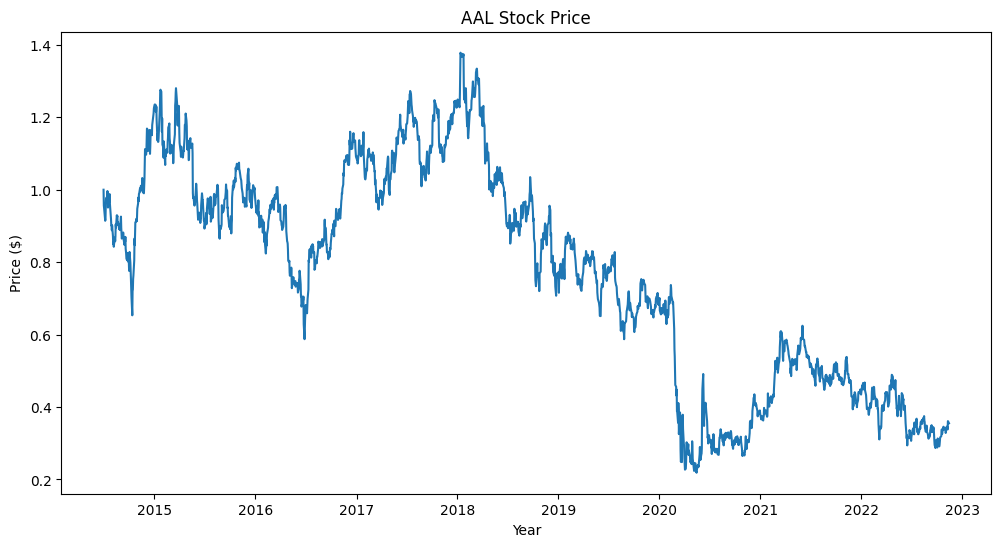

In [55]:
plt.figure(figsize=(12, 6))
plt.plot(AAL)
plt.title('AAL Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.show()

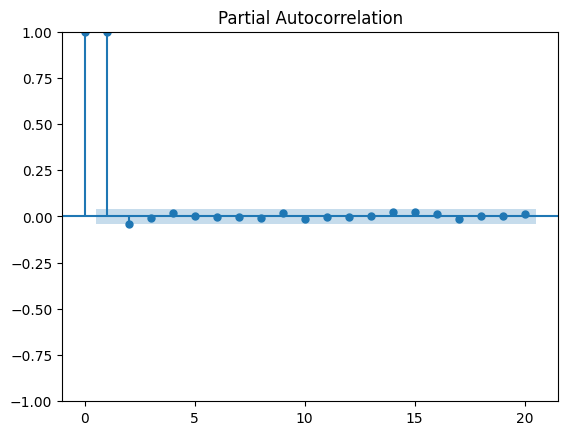

In [56]:
tsaplots.plot_pacf(AAL, lags=20);

In [57]:
AAL_diff = AAL.diff(periods=1).dropna()

As seen in the above graph, only the first term is non-zero. Therefore, we try differencing with $d=1$, i.e. we define the differenced series $Z_t = X_t - X_{t-1}$.

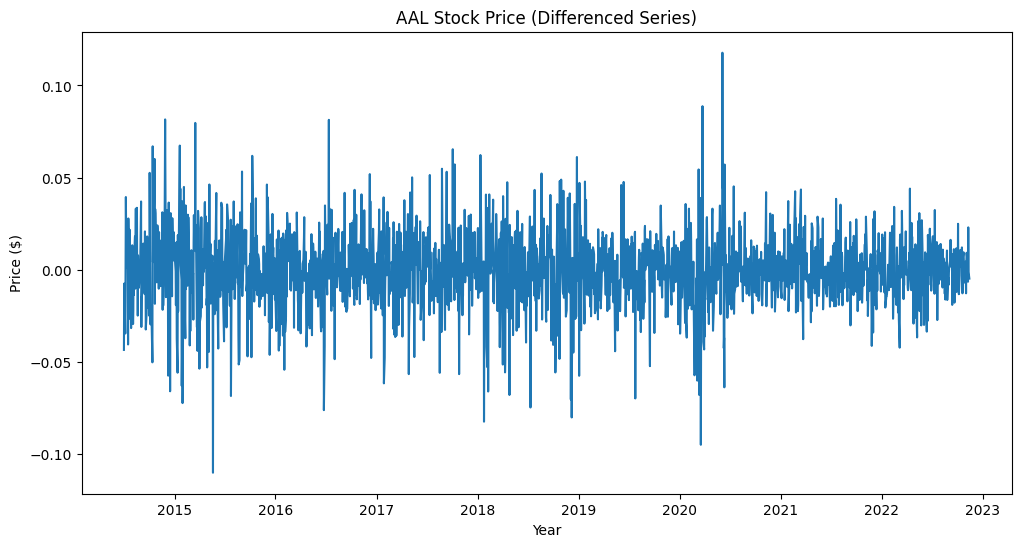

In [58]:
plt.figure(figsize=(12, 6))
plt.plot(AAL_diff)
plt.title('AAL Stock Price (Differenced Series)')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.show()

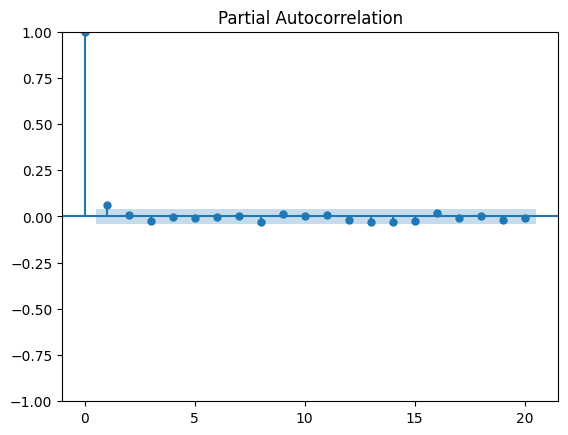

In [59]:
tsaplots.plot_pacf(AAL_diff, lags=20);

## SARIMA

### Dividing to Train, Validation and Test

In [109]:
train = AAL[data['set'] == 'train']
test = AAL[data['set'] == 'test']

844

In [100]:
def plot_predictions(train, test, predictions, model):
    plt.figure(figsize=(12, 6))
    plt.plot(train, label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label='Predictions', color='red')
    plt.title('AAL Stock Price Predictions ' + model)
    plt.xlabel('Year')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.show()

### Fitting SARIMA Model

As seen in the EDA, the differenced series mitigates the trednd present in the original data. Therefore, we fit a SARIMA model to the differenced series.

In [127]:
auto_sarima_model = auto_arima(train, seasonal=False,
                               d = 1, 
                               start_p = 0, start_q = 0, max_p = 4, max_q = 4,
                               start_P = 0, start_Q = 0, max_P = 4, max_Q = 4,
                               trace=True, error_action='warn', suppress_warnings=True,
                               random_state=42, n_fits=100)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6062.593, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6062.789, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6062.726, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6064.521, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6061.013, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.328 seconds


In [128]:
AAL_model = SARIMAX(train, order=auto_sarima_model.order, seasonal_order=auto_sarima_model.seasonal_order)
AAL_fit = AAL_model.fit(disp=False)
AAL_pred = AAL_fit.get_forecast(steps=len(test))
print(AAL_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1266
Model:               SARIMAX(0, 1, 0)   Log Likelihood                3033.261
Date:                Mon, 02 Sep 2024   AIC                          -6064.521
Time:                        17:18:59   BIC                          -6059.378
Sample:                             0   HQIC                         -6062.589
                               - 1266                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0005   1.44e-05     33.602      0.000       0.000       0.001
Ljung-Box (L1) (Q):                   2.19   Jarque-Bera (JB):               139.60
Prob(Q):                              0.14   Pr

/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a suppo

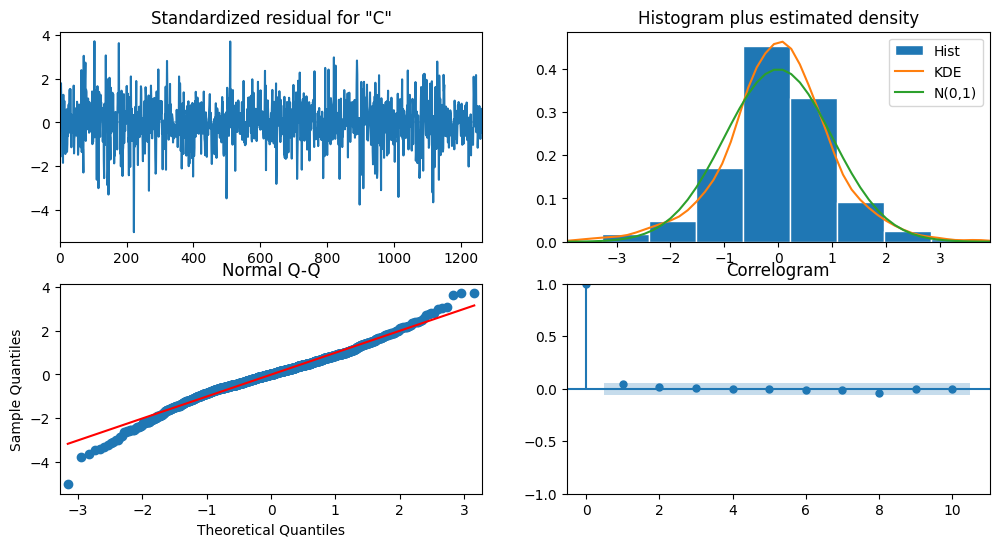

In [129]:
AAL_fit.plot_diagnostics(figsize=(12, 6));

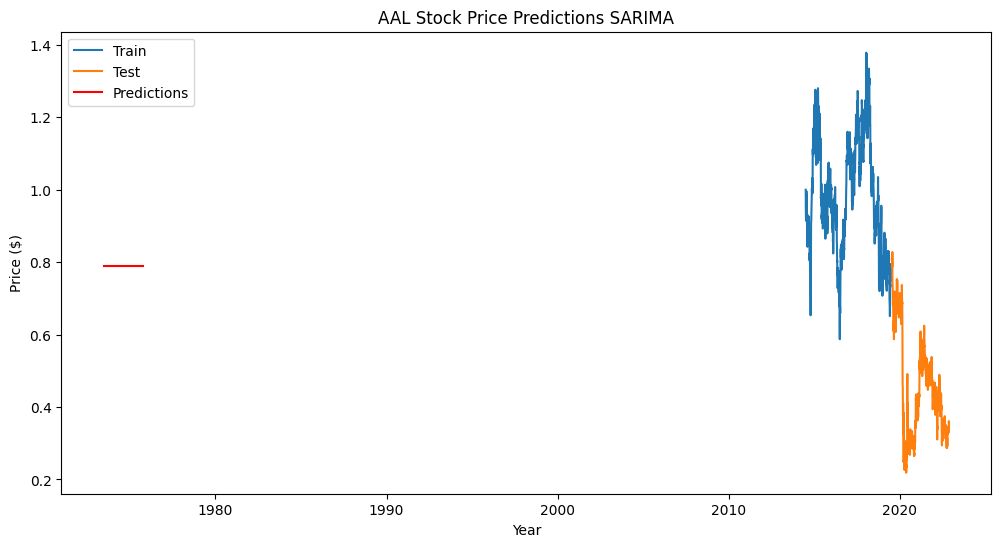

In [130]:
plot_predictions(train, test, AAL_pred.predicted_mean, 'SARIMA')

In [131]:
AAL_pred.predicted_mean

1266    0.790524
1267    0.790524
1268    0.790524
1269    0.790524
1270    0.790524
          ...   
2105    0.790524
2106    0.790524
2107    0.790524
2108    0.790524
2109    0.790524
Name: predicted_mean, Length: 844, dtype: float64